The transfer function for the causal LTI system with a realization $(A, B, C, D)$ is given by
\begin{equation*}
    H(s) = C(sI_{n} - A)^{-1}B.
\end{equation*}
Notice that $H(s) = Cv(s)$, where $v(s)$ is the solution of a parametrized linear coercive model
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$. In other words, we replace the matrix computation of $(sI_{n} - A)^{-1}B$ with a parametrized model (1). However, if one wants to apply this to the Iterative rational Krylov algorithm (IRKA), then the following matrix computations must be done to construct the projection matrices $V$ and $W$:
\begin{equation*}
    (-\mu_{i}I_{n} - A)^{-1}B\hat{b}_{i}, \quad \text{and} \quad (-\mu_{i}I_{n} - A)^{-*}C^{T}\hat{c}_{i} \quad \text{for } i = 1,\ldots,r,
\end{equation*}
where $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}$ are some initial interpolation data and $0 < r \leq n$ is the desired order of approximating ROM. So, we have decided to solve two parametrized linear coercive models to construct projection matrices $V$ and $W$:
\begin{equation}
    a_{1}(v_{1}, w; s) = l_{1}(w) \quad \text{and} \quad a_{2}(v_{2}, w; s) = l_{2}(w),
\end{equation}
where $a_{1}(v_{1}, w; s) = w^{*}(sI_{n} - A)v_{1}$ and $l_{1}(w) = w^{*}B$, and $a_{2}(v_{2}, w; s) = w^{*}(sI_{n} - A)^{*}v_{2}$ and $l_{2}(w) = w^{*}C^{T}$, and solutions to these parametrized linear coercive models are
\begin{equation*}
    v_{1}(s) = (sI_{n} - A)^{-1}B \quad \text{and} \quad v_{2}(s) = (sI_{n} - A)^{-*}C^{T}.
\end{equation*}
Therefore, knowing $v_{1}(\mu_{i})$ and $v_{2}(\mu_{i})$ for $i = 1, \ldots, r$ will suffice for constructing the projection matrices $V$ and $W$. Also, note that these two FOMs are parameter-separable, i.e.,
\begin{equation*}
    a_{1}(v_{1},w;s) = w^{*}(sI_{n} - A)v_{1} = sw^{*}I_{n}v_{1} - w^{*}Av_{1}  \quad  a_{2}(v_{2},w;s) = w^{*}(sI_{n} - A)^{*}v_{2} = \overline{s}w^{*}I_{n}v_{2} - w^{*}A^{*}v_{2}.
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pymor.basic import *
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import LincombOperator
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.parameters.functionals import ProjectionParameterFunctional
from pymor.vectorarrays.numpy import NumpyVectorSpace

### Constructing a stationary model
Let us construct a stationary model of the following parametrized linear coercive model using `pyMOR`:
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$.

In [2]:
def MatrixModel(A, B, dim: int):

    '''
    This function create a stationary model of the following linear coercive model derived for the given two matrices A and B:
    
        a(v, w; s) =w^{*}(sI_{n} - A)v and l(w) = w^{*}B.
    '''
    
    # Create Numpy vector space
    vector_space = NumpyVectorSpace(dim)

    # Define NumpyMatrixOperators
    I_op = NumpyMatrixOperator(np.eye(dim))

    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        A_op = NumpyMatrixOperator(A)
        B_op = NumpyMatrixOperator(B.reshape(-1, 1))
    else:
        A_op = A
        B_op = B       

    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w^* (sI - A)v
    a_op = LincombOperator([I_op, A_op], [s_param, -1])

    # Define linear functional l(w) = w^*B
    l_op = B_op

    # Define the StationaryModel
    model = StationaryModel(operator = a_op, rhs = l_op)

    return model

### Examples
Notice that to make this process more convenient, we provide two options for input matrices. If one has the matrices as `NumPy` arrays, they can import them directly without changing their type to work with `pyMOR`. Additionally, if one wants to input matrices from existing `pyMOR` models, this can also be done directly. To demonstrate this, we provide two examples: one with random matrices that we construct ourselves, and the other with matrices imported from the `penzl_example` in `pymor.models.examples`.


In [3]:
# Stationary model constructed using random numpy arrays

# Randomly generated arrays
np.random.seed(127)
matrixA = np.random.rand(20, 20)
matrixB = B = np.random.rand(20)

model_numpy = MatrixModel(A = matrixA, B = matrixB, dim = 20)
model_numpy

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True)

In [4]:
# Set parameter for evaluation
parameter = {'s': 1.4}  # s = 1.4

# Solve the model
solution = model_numpy.solve(parameter).to_numpy()

# Exact matrix computation
exact = (inv(parameter['s']*np.eye(20) - matrixA)@matrixB).reshape(1, 20)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The exact value of the matrix computation (1.4I - A)^{-1}B is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The L-infinity error is 2.4424906541753444e-15.


In [5]:
# Stationary model constructed using matrices obtained from penzl example
from pymor.models.examples import penzl_example

penzl = penzl_example()

model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)
model_penzl

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<1006x1006 dense>), NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<1006x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(1006)),
    products={},
    output_d_mu_use_adjoint=True)

In [6]:
from pymor.algorithms.to_matrix import to_matrix

# Set parameter for evaluation
parameter = {'s': -1 + 2*1j}  # s = - 1 + 2i

# Solve the model
solution = model_penzl.solve(parameter).to_numpy()

# Exact matrix computation
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

exact = (inv(parameter['s']*np.eye(penzl.order) - matrixA)@matrixB).reshape(1, penzl.order)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The exact value of the matrix computation ((-1+2j)I - A)^{-1}B is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The L-infinity error is 2.7755575615628914e-17.


## Reduced Basis Methods

As an example, we will use `penzl_example` from `pymor.models.examples` to construct a reduced basis using the reduced basis methods available in `pyMOR`.

In [7]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

### POD-Galerkin Method

In [8]:
# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a training set
training_set = parameter_space.sample_randomly(50)

# Compute FOM solutions for the parameters in the training set
solution_snapshots = model_penzl.solution_space.empty()
for s in training_set:
    solution_snapshots.append(model_penzl.solve(s))

# Snapshot matrix S
snapshot_matrix = solution_snapshots.to_numpy().T
print(f'An {snapshot_matrix.shape[0]} by {snapshot_matrix.shape[1]} snapshot matrix is \n {snapshot_matrix}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

An 1006 by 50 snapshot matrix is 
 [[ 0.10791712  0.10508859  0.10858926 ...  0.1037334   0.10717139
   0.10234687]
 [-0.09056608 -0.09433111 -0.08958912 ... -0.09596436 -0.09161048
  -0.0975374 ]
 [ 0.05208595  0.05131127  0.05227672 ...  0.05095332  0.05187756
   0.05059421]
 ...
 [ 0.00099429  0.00099761  0.00099346 ...  0.00099911  0.0009952
   0.00100059]
 [ 0.0009933   0.00099662  0.00099247 ...  0.00099811  0.00099421
   0.00099959]
 [ 0.00099232  0.00099562  0.00099149 ...  0.00099712  0.00099322
   0.0009986 ]]


In [9]:
# Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True) # using 'pod_basis, pod_singular_values = pod(solution_snapshots)' gives wrong result (pod_basis._len != 10 (5 != 10)); that's why we don't use it here. 

# Activate below to automatically select the number of modes based on the energy criterion
## The number of modes m should be chosen based on the energy criterion, which ensures that a sufficient portion of the system's total energy (or variance) is captured by the first m modes.
#cumulative_energy = np.cumsum(D**2) / np.sum(D**2)

##Select the number of modes m to capture at least 95% of the energy
#threshold = 0.95  # 95% of the total energy
#m = np.argmax(cumulative_energy >= threshold) + 1

m = 20 # this is also a reduction order

if m > min(snapshot_matrix.shape):
    raise ValueError("m cannot exceed the rank of the snapshot matrix.")

# The reduced basis (POD basis)
pod_basis_numpy = U[:,:m]
print(f'The reduced basis (containing the first {m} left singular vectors (POD modes) of the snapshot matrix as its columns) is \n {pod_basis_numpy}')

The reduced basis (containing the first 20 left singular vectors (POD modes) of the snapshot matrix as its columns) is 
 [[-0.19696096 -0.31340348  0.36198988 ... -0.00431519 -0.00049817
   0.00223207]
 [ 0.17630327  0.23589406 -0.16498272 ... -0.0379153  -0.02853059
   0.00898774]
 [-0.09617923 -0.14845524  0.1618159  ...  0.36862449  0.29847176
  -0.06855028]
 ...
 [-0.0018688  -0.00275277  0.0026819  ... -0.0157844   0.00189082
  -0.00276168]
 [-0.00186694 -0.00275005  0.00267931 ... -0.00445315 -0.0062538
  -0.00233055]
 [-0.00186508 -0.00274733  0.00267672 ...  0.00197302 -0.00953304
   0.00471574]]


In [10]:
from pymor.reductors.basic import StationaryRBReductor

# Convert NumPy array into VectorArray 
'''
The two lines below are the correct way to convert a NumPy reduced basis array into a VectorArray. However, the 'StationaryRBReductor' raises an error because 
'pod_basis in model_penzl.solution_space' is set to False. This happens because 'pod_basis.dim' is not equal to 'model_penzl.solution_space.dim'. This is 
expected since pod_basis.dim equals m (the number of modes, which can vary and is not fixed), whereas model_penzl.solution_space.dim is a fixed integer.
'''
#space = NumpyVectorSpace(m)
#pod_basis = space.make_array(pod_basis_numpy)

space = NumpyVectorSpace(model_penzl.order)
pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

# POD-Galerkin RB method
pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
pod_rom = pod_reductor.reduce()
pod_rom

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True,
    name='StationaryModel_reduced')

In [11]:
import time

# Start timing
start_time_reduce = time.time()

# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a validation set
r = 10
validation_set = parameter_space.sample_randomly(r)

# Solution array containing r many reduced samples
reduced_solution = pod_rom.solution_space.empty()
for s in validation_set:
    reduced_solution.append(pod_rom.solve(s))

# End timing
end_time_reduce = time.time()

# Compute and print the elapsed time
elapsed_time_reduce = end_time_reduce - start_time_reduce

# Reconstruct high-dimensional vector from reduced vector (necessary for error analysis)
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

print(f'The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is \n {reduced_solution_reconstruct}')

The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is 
 [[ 0.10291402 -0.09690529  0.0507403  ...  0.00099999  0.00099899
   0.000998  ]
 [ 0.10107168 -0.09890484  0.05026941 ...  0.00100192  0.00100092
   0.00099992]
 [ 0.10802123 -0.09041703  0.05211531 ...  0.00099416  0.00099318
   0.00099219]
 ...
 [ 0.1062161  -0.09289231  0.05161515 ...  0.00099632  0.00099533
   0.00099434]
 [ 0.1023473  -0.09753694  0.05059432 ...  0.00100059  0.00099959
   0.0009986 ]
 [ 0.10210677 -0.09780046  0.05053268 ...  0.00100085  0.00099985
   0.00099885]]


In [12]:
## Exact matrix computation

# Start timing
start_time_exact = time.time()

matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# End timing
end_time_exact = time.time()

# Compute and print the elapsed time
elapsed_time_exact = end_time_exact - start_time_exact

In [13]:
## Error analysis

# Start timing
start_time_full = time.time()

# FOM solution
full_solution = model_penzl.solution_space.empty()
for s in validation_set:
    full_solution.append(model_penzl.solve(s))
    
# End timing
end_time_full = time.time()

# Compute and print the elapsed time
elapsed_time_full = end_time_full - start_time_full

# Convert FOM solution into NumPy array
full_solution_numpy = full_solution.to_numpy()

# ROM solution
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()

# Norms for each training data - > output is an array
error_exact = exact_solution - reduced_solution_reconstruct_numpy
error_fom = full_solution_numpy - reduced_solution_reconstruct_numpy
num_rows = error_exact.shape[0]
linfnorm_exact = np.zeros(num_rows)
l2norm_exact = np.zeros(num_rows)
linfnorm_fom = np.zeros(num_rows)
l2norm_fom = np.zeros(num_rows)
for row_number in range(num_rows):
    linfnorm_exact[row_number] = np.linalg.norm(error_exact[row_number], np.inf)
    l2norm_exact[row_number] = np.linalg.norm(error_exact[row_number], 2)  
    linfnorm_fom[row_number] = np.linalg.norm(error_fom[row_number], np.inf)
    l2norm_fom[row_number] = np.linalg.norm(error_fom[row_number], 2)  

# Printing error results
print('-'*20 + ' Look below to check if things are going well '+'-'*30)
print(f'[The L-infinity norm] The best is {min(linfnorm_exact)} and worst is {max(linfnorm_exact)}.')
print(f'[The L-2 norm] The best is {min(l2norm_exact)} and worst is {max(l2norm_exact)}.')
print('-'*20 + ' Linf and L2 norms (array) of error vectors '+'-'*30)
print(f'The L-infinity norm of (Exact solution - ROM solution) is {linfnorm_exact}.')
print(f'The L-infinity norm of (FOM solution - ROM solution) is {linfnorm_fom}.')
print(f'The L-2 norm of (Exact solution - ROM solution) is {l2norm_exact}.')
print(f'The L-2 norm of (FOM solution - ROM solution) is {l2norm_fom}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

-------------------- Look below to check if things are going well ------------------------------
[The L-infinity norm] The best is 1.5681900222830336e-15 and worst is 5.55056001161347e-13.
[The L-2 norm] The best is 2.079166373371179e-15 and worst is 9.56338260479398e-13.
-------------------- Linf and L2 norms (array) of error vectors ------------------------------
The L-infinity norm of (Exact solution - ROM solution) is [4.38538095e-15 5.55056001e-13 1.58206781e-15 1.77635684e-15
 1.76247905e-15 1.56819002e-15 2.52575738e-15 2.08166817e-15
 5.77315973e-15 5.82867088e-15].
The L-infinity norm of (FOM solution - ROM solution) is [4.38538095e-15 5.55056001e-13 1.58206781e-15 1.77635684e-15
 1.76247905e-15 1.56819002e-15 2.52575738e-15 2.08166817e-15
 5.77315973e-15 5.82867088e-15].
The L-2 norm of (Exact solution - ROM solution) is [5.56674409e-15 9.56338260e-13 2.07916637e-15 2.38565582e-15
 2.31734901e-15 2.11527765e-15 3.26611924e-15 2.72346172e-15
 7.22076397e-15 7.44129153e-15].
Th

In [14]:
# Computational time analysis (execution time analysis)
print(f'Total computation time of POD-Galerkin ROM: {elapsed_time_reduce:.10f} seconds.')
print(f'Total computation time of FOM: {elapsed_time_full:.10f} seconds.')
print(f'Total computation time of Exact: {elapsed_time_exact:.10f} seconds.')

Total computation time of POD-Galerkin ROM: 0.0090703964 seconds.
Total computation time of FOM: 0.4948282242 seconds.
Total computation time of Exact: 1.8764305115 seconds.


## Summary of POD-Galerkin Method

In [15]:
def MatrixReductor(A, B, dim: int, training_set, validation_set, reduced_order: int):

    # Construct Matrix induced StationaryModel
    model_penzl = MatrixModel(A, B, dim = dim)

    # Compute FOM solutions for the parameters in the training set
    solution_snapshots = model_penzl.solution_space.empty()
    for s in training_set:
        solution_snapshots.append(model_penzl.solve(s))

    # Snapshot matrix S
    snapshot_matrix = solution_snapshots.to_numpy().T

    # Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
    U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True)

    if reduced_order > min(snapshot_matrix.shape):
        raise ValueError("'reduced_order' cannot exceed the rank of the snapshot matrix.")

    # The reduced basis (POD basis)
    pod_basis_numpy = U[:,:reduced_order]

    # Convert NumPy array into VectorArray 
    space = NumpyVectorSpace(model_penzl.order)
    pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

    # POD-Galerkin RB method
    pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
    pod_rom = pod_reductor.reduce()

    # Solution array containing r many reduced samples
    reduced_solution = pod_rom.solution_space.empty()
    for s in validation_set:
        reduced_solution.append(pod_rom.solve(s))

    return [reduced_solution, pod_reductor]

### Examples (with both real and complex parameters)

#### Real-valued training and validation set
In this subsection, we will examine the Matrix Reduction method using a real-valued training set and validation set for real parameters. As an example, we will use `penzl_example` from `pymor.models.examples`.

In [16]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

A = penzl.A
B = penzl.B
dim = penzl.order 
parameter_space = model_penzl.parameters.space(0.01, 10.)
training_set = parameter_space.sample_randomly(30)
validation_set = parameter_space.sample_randomly(10)

[reduced_solution, pod_reductor] = MatrixReductor(A, B, dim, training_set, validation_set, reduced_order = 15) # reduced_order must be less than or equal to len(training_set)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
reduced_solution_reconstruct_numpy

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

array([[ 0.10246593, -0.09740597,  0.05062479, ...,  0.00100047,
         0.00099947,  0.00099847],
       [ 0.1072854 , -0.09145339,  0.0519092 , ...,  0.00099506,
         0.00099407,  0.00099308],
       [ 0.10515281, -0.09425119,  0.05132842, ...,  0.00099754,
         0.00099654,  0.00099555],
       ...,
       [ 0.10184941, -0.0980795 ,  0.05046692, ...,  0.00100112,
         0.00100011,  0.00099912],
       [ 0.10213994, -0.09776428,  0.05054117, ...,  0.00100081,
         0.00099981,  0.00099881],
       [ 0.10938581, -0.08838393,  0.05250681, ...,  0.00099244,
         0.00099145,  0.00099047]])

In [17]:
# Converting matrices to numpy arrays
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data for an error plot
order_list = np.arange(1, 16)
linf_list = np.zeros(15)
l2_list = np.zeros(15)
for i in range(15):
    [reduced_solution, pod_reductor] = MatrixReductor(A, B, dim, training_set, validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

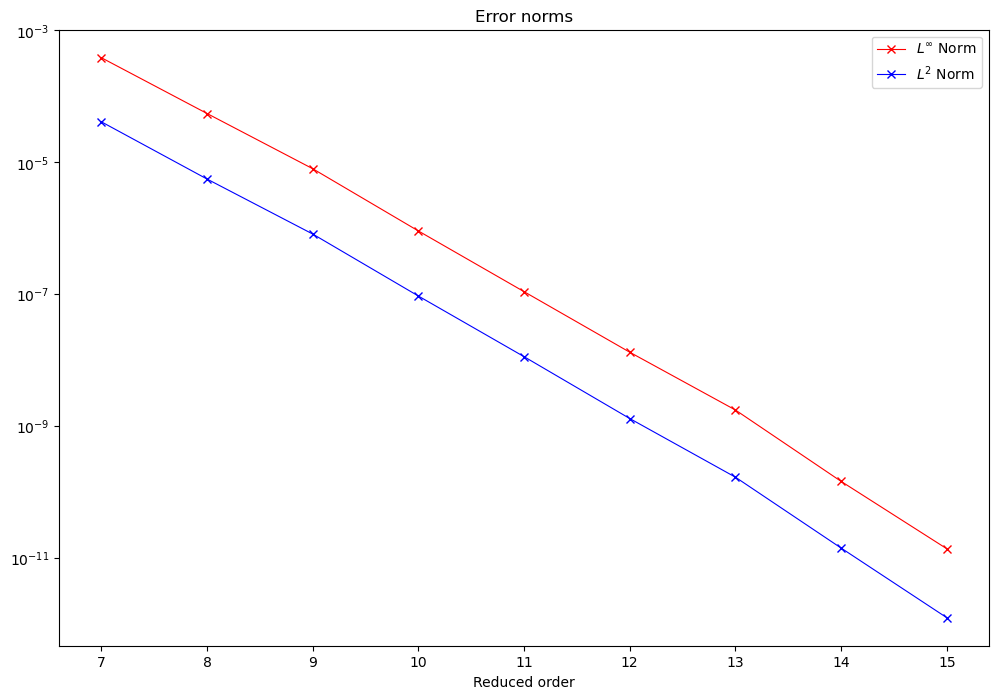

In [18]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.semilogy(order_list[6:], linf_list[6:], label = r"$L^\infty$ Norm", color='red', lw = 0.8, marker = 'x')
ax.semilogy(order_list[6:], l2_list[6:], label = r"$L^2$ Norm", color='blue', lw = 0.8, marker = 'x')
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

#### Complex-valued training and validation set (A Vital Step for IRKA)
In this subsection, we will examine the Matrix Reduction method using a complex-valued training set and validation set for complex parameters. For the IRKA method, we need to compute matrices at complex-valued interpolation points, and we will check if it works for complex parameters as well. As an example, we will use `penzl_example` from `pymor.models.examples`.

In [25]:
from pymor.parameters.base import Mu

# Create a complex-valued training set
card_training_set = 40
complex_parameters = 10*np.random.random_sample((card_training_set,)) + 10*1j*np.random.random_sample((card_training_set,))
imaginary_training_set = []
for i in range(card_training_set):
    imaginary_training_set.append(Mu({'s': np.array(complex_parameters[i])}))

# Create a complex-valued validation set
card_validation_set = 10
complex_parameters_validation = 15*np.random.random_sample((card_training_set,)) + 15*1j*np.random.random_sample((card_training_set,))
imaginary_validation_set = []
for k in range(10):
    imaginary_validation_set.append(Mu({'s': np.array(complex_parameters_validation[k])}))
print(f'An complex-valued training set is {imaginary_training_set}.')
print(f'An complex-valued validation set is {imaginary_validation_set}.')

An complex-valued training set is [Mu({'s': array([6.30034185+6.7779432j])}), Mu({'s': array([0.8001465+5.91385779j])}), Mu({'s': array([3.22654103+1.23297928j])}), Mu({'s': array([2.42504489+0.48607346j])}), Mu({'s': array([4.57114881+3.05795805j])}), Mu({'s': array([4.67028918+5.5042268j])}), Mu({'s': array([5.11527028+0.86738622j])}), Mu({'s': array([5.32244529+4.34511111j])}), Mu({'s': array([1.75908335+2.61029591j])}), Mu({'s': array([0.97770643+9.03316968j])}), Mu({'s': array([3.32791901+4.88314447j])}), Mu({'s': array([0.85718623+6.98540315j])}), Mu({'s': array([2.75469293+4.16110571j])}), Mu({'s': array([5.37283289+6.51012584j])}), Mu({'s': array([2.56290132+8.10465305j])}), Mu({'s': array([0.24025289+4.90409301j])}), Mu({'s': array([5.70224158+3.89353674j])}), Mu({'s': array([7.22064392+5.76024652j])}), Mu({'s': array([7.013763+9.40021986j])}), Mu({'s': array([8.53555293+1.77407142j])}), Mu({'s': array([9.04663266+3.53554413j])}), Mu({'s': array([5.32008741+2.96092752j])}), Mu

In [26]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

A = penzl.A
B = penzl.B
dim = penzl.order 

# Reduced solution
reduced_order = 35
[reduced_solution, pod_reductor] = MatrixReductor(A, B, dim, imaginary_training_set, imaginary_validation_set, reduced_order = reduced_order)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
reduced_solution_reconstruct_numpy

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

array([[ 0.10592077+4.20481629e-03j, -0.09381043+5.36713685e-03j,
         0.05149357+1.13149966e-03j, ...,  0.00099695-4.79825543e-06j,
         0.00099596-4.78870247e-06j,  0.00099497-4.77917801e-06j],
       [ 0.1119116 +2.76531109e-03j, -0.08462725+4.94422290e-03j,
         0.05322906+8.65122895e-04j, ...,  0.00098926-3.98906130e-06j,
         0.00098829-3.98118054e-06j,  0.00098731-3.97332310e-06j],
       [ 0.10839292+4.58406125e-03j, -0.09067659+6.58060898e-03j,
         0.05215423+1.29143466e-03j, ...,  0.00099416-5.63094061e-06j,
         0.00099317-5.61976117e-06j,  0.00099219-5.60861500e-06j],
       ...,
       [ 0.10869046+3.59905296e-03j, -0.08995415+5.28681203e-03j,
         0.05226234+1.02477541e-03j, ...,  0.00099363-4.49530003e-06j,
         0.00099264-4.48638003e-06j,  0.00099166-4.47748655e-06j],
       [ 0.10375864+1.95311497e-03j, -0.09603288+2.28090883e-03j,
         0.05095281+5.10336059e-04j, ...,  0.00099913-2.12188430e-06j,
         0.00099814-2.11765056e-06j

In [27]:
# Converting matrices to numpy arrays
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in imaginary_validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data
reduced_order_error = 30
order_list = np.arange(1, reduced_order_error + 1)
linf_list = np.zeros(reduced_order_error)
l2_list = np.zeros(reduced_order_error)
for i in range(reduced_order_error):
    [reduced_solution, pod_reductor] = MatrixReductor(A, B, dim, imaginary_training_set, imaginary_validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Hooray!🎉 It also seems to handle complex parameters

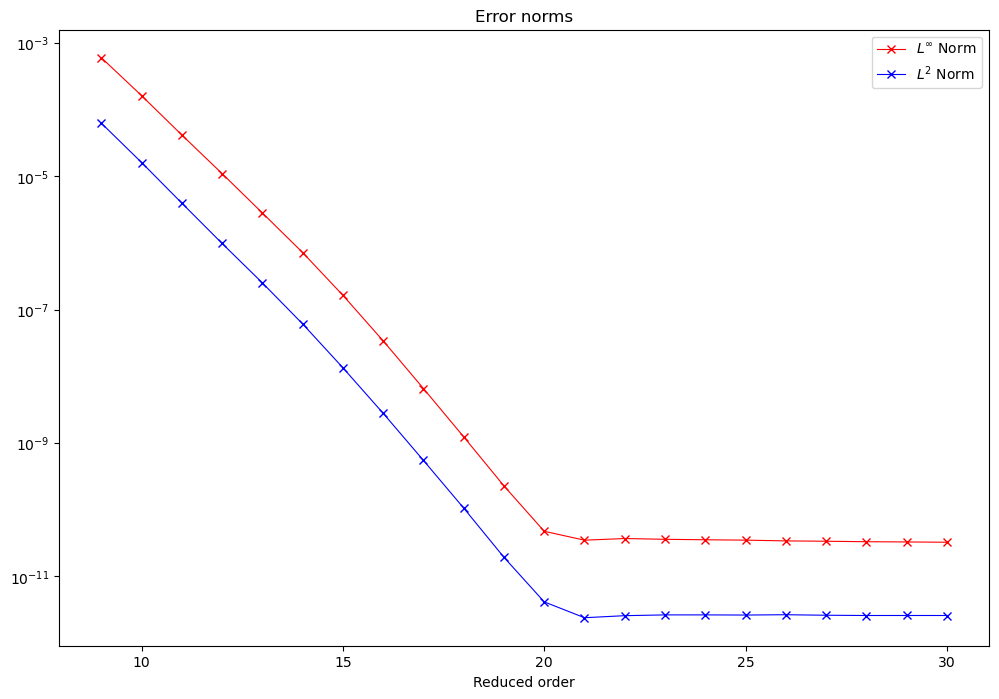

In [32]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.semilogy(order_list[8:], linf_list[8:], label = r"$L^\infty$ Norm", color='red', lw = 0.8, marker = 'x')
ax.semilogy(order_list[8:], l2_list[8:], label = r"$L^2$ Norm", color='blue', lw = 0.8, marker = 'x')
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

### Greedy Reduced Basis Method